# Data : read & prepare

In [1]:
train <- read.csv2('TrainSample.csv')

In [2]:
nums <- sapply(train, is.numeric)
gasPred <- train[ , nums]
gasPred$API <- NULL

oilPred <- gasPred

gasPred$OilCum360 <- NULL
oilPred$GasCum360 <- NULL

# Linear regression

In [3]:
gasModel <- lm(GasCum360 ~ ., gasPred)
summary(gasModel)


Call:
lm(formula = GasCum360 ~ ., data = gasPred)

Residuals:
   Min     1Q Median     3Q    Max 
-50447 -13633  -2456  11484  78781 

Coefficients:
                             Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   60820.9     2728.7  22.289  < 2e-16 ***
Surf_X                       -44851.9    21784.6  -2.059  0.04045 *  
Surf_Y                       -41236.3    31282.7  -1.318  0.18855    
Lateral_Length..ft.           28696.4     5497.5   5.220 3.55e-07 ***
Depth_TVD_PPLS..ft.          -28869.4    20105.0  -1.436  0.15217    
Erosion_PPLS..ft.             -1534.2     2827.2  -0.543  0.58781    
Pressure_PPLS..PSI.            -992.1     3123.0  -0.318  0.75096    
TOC_PPLS....                 -18480.2     4219.3  -4.380 1.69e-05 ***
Vcarb_PPLS                   -33401.8    14728.4  -2.268  0.02412 *  
Vsand_PPLS                    -7473.7    10104.0  -0.740  0.46013    
Vclay_PPLS                    -9429.2     8304.4  -1.135  0.25718    
PR_PPLS   

In [4]:
oilModel <- lm(OilCum360 ~ ., oilPred)
summary(oilModel)


Call:
lm(formula = OilCum360 ~ ., data = oilPred)

Residuals:
    Min      1Q  Median      3Q     Max 
-1797.5  -293.8    -2.7   277.8  4125.0 

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)    
(Intercept)                   1321.122     87.919  15.027  < 2e-16 ***
Surf_X                          19.031    701.899   0.027  0.97839    
Surf_Y                         900.107   1007.930   0.893  0.37263    
Lateral_Length..ft.           -576.848    177.129  -3.257  0.00127 ** 
Depth_TVD_PPLS..ft.            731.822    647.784   1.130  0.25958    
Erosion_PPLS..ft.               47.388     91.092   0.520  0.60333    
Pressure_PPLS..PSI.            -78.414    100.622  -0.779  0.43648    
TOC_PPLS....                   584.976    135.946   4.303 2.35e-05 ***
Vcarb_PPLS                    1016.446    474.549   2.142  0.03308 *  
Vsand_PPLS                     505.079    325.550   1.551  0.12195    
Vclay_PPLS                     370.684    267.568   1.385  

# Results


## Gas

Warning message:
In predict.lm(gasModel, interval = "pred") :
  predictions on current data refer to _future_ responses



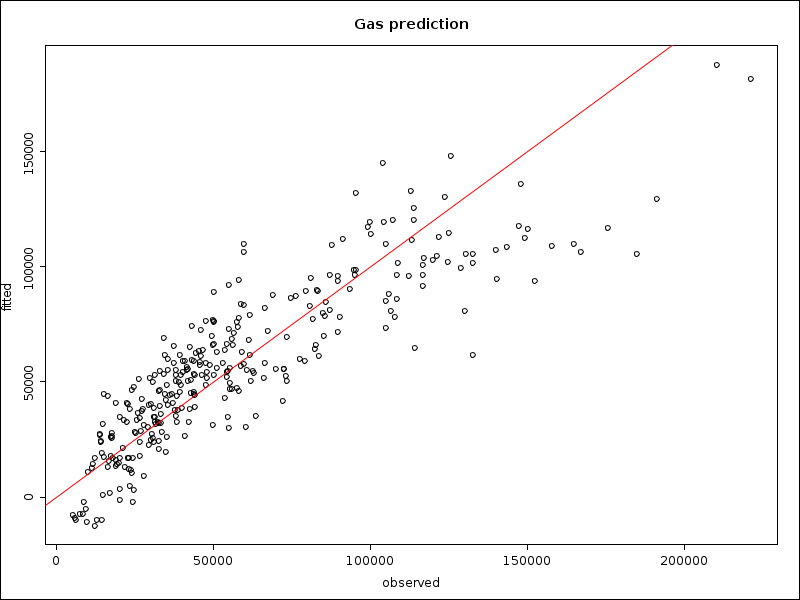

In [5]:
gasPredicted <- predict(gasModel, interval = "pred")
plot(gasModel$model[,1], gasPredicted[,1], ylab = "fitted", xlab = "observed",
    main = "Gas prediction")
abline(a=0, b=1, col =2)

## Oil

Warning message:
In predict.lm(oilModel, interval = "pred") :
  predictions on current data refer to _future_ responses



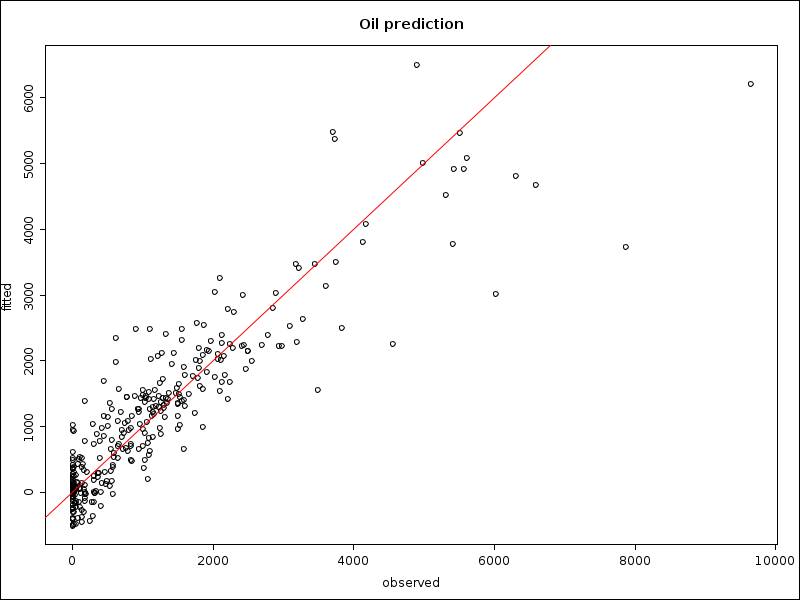

In [6]:
oilPredicted <- predict(oilModel, interval = "pred")
plot(oilModel$model[,1], oilPredicted[,1], ylab = "fitted", xlab = "observed",
    main = "Oil prediction")
abline(a=0, b=1, col =2)

## Cross-validation example (gas)

In [7]:
library(DiceEval)

Y <- gasModel$model[,1]
X <- data.frame(gasModel$model[,2:ncol(gasModel$model)])
colnames(X) <- c(paste( "X", c(1:ncol(X)), sep=""))
formula <- as.formula(paste("Y~", paste (paste("X", c(1:ncol(X)), sep=""),
                                         collapse="+"),sep=""))


model.CV <- modelFit(X,Y, type = "Linear", formula = formula)

## Nombre de groupes :
K <- 3

## Validation croisée :
CV <- crossValidation(model.CV ,K=K)

Loading required package: DiceKriging


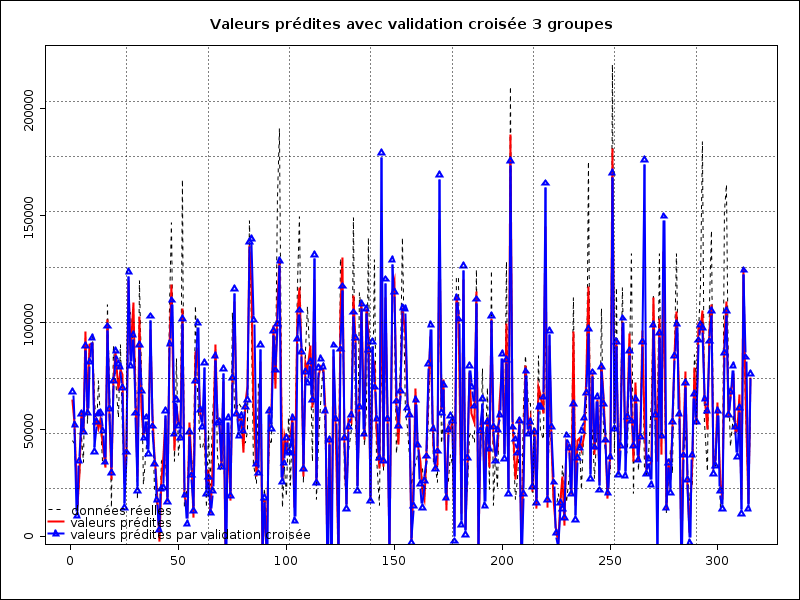

In [8]:
# plot

plot(as.ts(Y), lty = 2, xlab = "", ylab = "", 
     main = paste("Valeurs prédites avec validation croisée ",K," groupes",sep=""))
lines(as.ts(model.CV$model$fitted.values), lwd = 2, col = 'red')
lines(as.ts(CV$Ypred), type = 'b', lwd = 2, pch = 2, col = 'blue')
box()
grid(9,lwd=1, col="1")
legend("bottomleft",
       c("données réelles", "valeurs prédites", "valeurs prédites par validation croisée"),
       lwd = c(1,2,2), lty = c(2,1,1), pch = c(NA,NA,2), col = c('black', 'red', 'blue'),
       cex = 1, bty="n")

# Prediction

In [9]:
test <- read.csv2('TestSample.csv')
test[is.na(test)] <- 0

In [10]:
testGas <- predict(gasModel, newdata = test, interval = 'confidence')
testOil <- predict(oilModel, newdata = test, interval = 'confidence')

In [11]:
results <- data.frame(ID = test$API,
                      CUM360_INF = testOil[,2],
                      CUM360_SUP = testOil[,3],
                      GAS360_INF = testGas[,2],
                      GAS360_SUP = testGas[,3])

head(results)

In [13]:
write.table(results, "submit.csv", sep = ";",
            quote = FALSE, row.names = FALSE)

# Random forest

## CART

## Random forest

In [34]:
library(randomForest)

oilPred2 <- na.omit(oilPred)

oilModelRF <- randomForest(OilCum360 ~ ., oilPred2, ntree = 300)
oilModelRF


Call:
 randomForest(formula = OilCum360 ~ ., data = oilPred2, ntree = 300) 
               Type of random forest: regression
                     Number of trees: 300
No. of variables tried at each split: 13

          Mean of squared residuals: 409871.1
                    % Var explained: 79.59


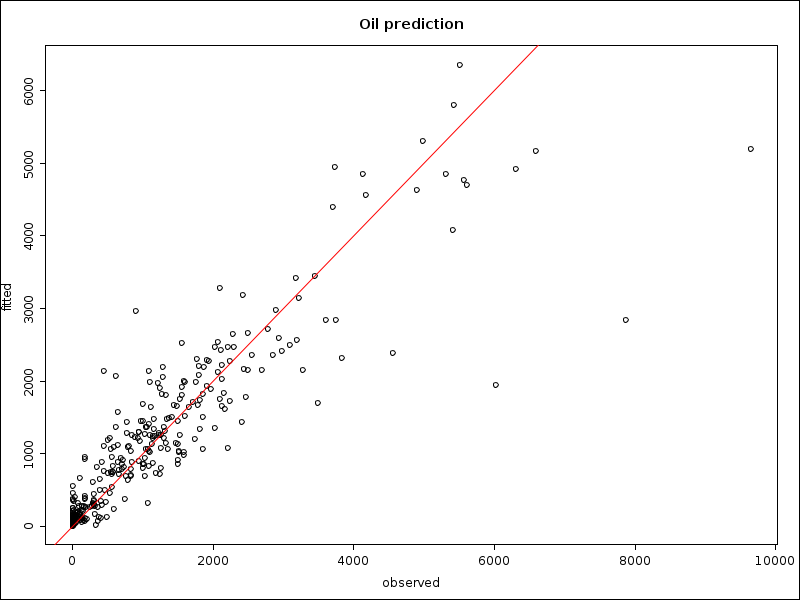

In [35]:
plot(oilPred2$OilCum360, oilModelRF$predicted, ylab = "fitted", xlab = "observed",
    main = "Oil prediction")
abline(a=0, b=1, col =2)

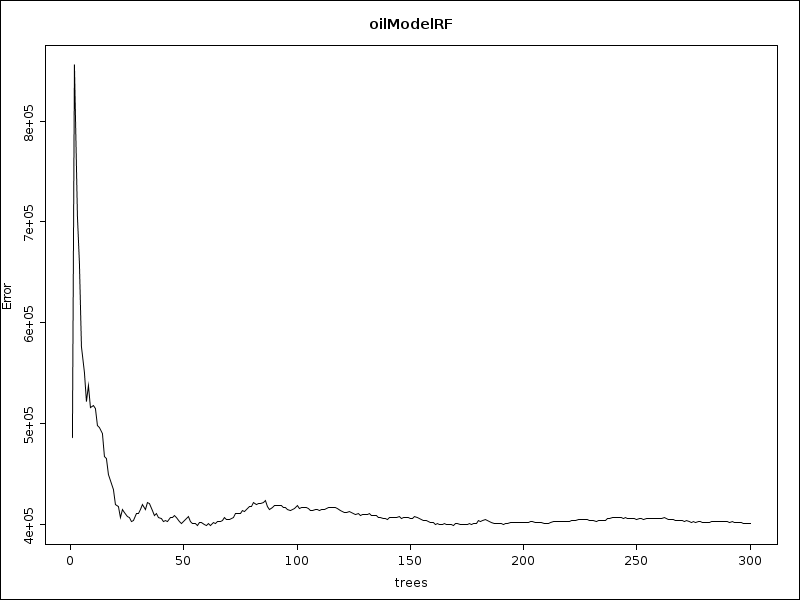

In [30]:
plot(oilModelRF)

# Random forest with IC

In [36]:
library(randomForestCI)
library(dplyr)
library(ggplot2)

In [37]:
rf <- randomForest(OilCum360 ~ ., oilPred2, keep.inbag = TRUE, replace = TRUE)

rfCI <-  randomForestInfJack(rf, X, calibrate = TRUE)

Error in randomForestInfJack(rf, X, calibrate = TRUE) : 
  The keep.inbag field must store the number of times each observation was used. Please make sure the version number of randomForest is 4.6-12 or higher.
